In [1]:
import numpy as np
import scipy.fft
import scipy.signal as ss
import scipy.ndimage as si
import scipy.stats as st
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as tck
from mpl_toolkits.mplot3d import axes3d, Axes3D
import seaborn as sns
import PIL.Image
from IPython import display
mpl.rcParams['axes.titlesize']=13
style = {'axes.facecolor': 'whitesmoke','axes.grid':True}
bpp = {'L': ['Escala de grises', 8], 'RGB': ['Truecolor', 24], 'RGBA': ['Deepcolor', 32]}

In [33]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Clickear acá para mostrar/ocultar código."></form>''')

***
<h1 style="color:black;font-size:40px"><center>MÓDULO 4</center></h1>

***
***

# 4.2 Actividad 10

***
>***b) En el programa que uses habitualmente, hacé la misma operación haciendo uso de alguna función del lenguaje (conv2 y/o imfilter en Octave/Matlab).<br> 
En caso que exista alguna diferencia respecto del resultado que obtuviste antes con tu cálculo "a lápiz y papel", comentala en el foro y explicala.***
***

***Creo las matrices...***

In [3]:
A = np.zeros((5,5))
A[1,2], A[2,1], A[2,2], A[2,3], A[3,2] = 4, 1, 2, 3, 5 
W = np.zeros((3,3))
W[1,2]=1
print(A, '\n')
print(W)

[[0. 0. 0. 0. 0.]
 [0. 0. 4. 0. 0.]
 [0. 1. 2. 3. 0.]
 [0. 0. 5. 0. 0.]
 [0. 0. 0. 0. 0.]] 

[[0. 0. 0.]
 [0. 0. 1.]
 [0. 0. 0.]]


***Las convoluciono...***

In [4]:
ss.convolve(A, W, mode='same')

array([[0., 0., 0., 0., 0.],
       [0., 0., 0., 4., 0.],
       [0., 0., 1., 2., 3.],
       [0., 0., 0., 5., 0.],
       [0., 0., 0., 0., 0.]])

***Se observa que la convolición con una delta desplazada una cierta magnitud desplaza la matriz/función original en esa magnitud, lo cual tiene sentido con lo propiedad general de la delta...***
$$
x[n]*\delta[n-n_0] = x[n-n_0] 
$$

***Mecánicamente esto ocurre porque la convolución, a diferencia de la correlación, implica una rotación de 180$^\circ$ del kernel.*** 

***
***

# 4.3 Actividad 11

>***Aplicar a una imagen<br>
-un filtro suavizante<br>
-un filtro laplaciano***

>***Luego:<br>
>a) Comparar las imágenes antes y después del filtrado. Describir los efectos en el dominio espacial.<br>
b) Comparar los espectros de magnitud de las imágenes antes y después del filtrado. Describir los efectos observados en el dominio frecuencial.<br>
c) ¿se te ocurre alguna estrategia para logar tener una imagen con los bordes realzados, pero no solamente los bordes? ¿Cuál podría ser el filtro que devuelva una imagen con esas características?***

***Abro la imagen y miro qué tipo de dato es...*** 

In [5]:
# Creo una función para abrir la imagen y la prof de bits..
def abrir(file):
    img = mpl.image.imread(file)
    print('Tipo de dato:', img.dtype)
    bd = int(img.nbytes*8/img.size)
    return img, bd
img, bd = abrir('Data/Torax.bmp')

Tipo de dato: uint8


***Aplico filtro suavizante de promedio simple...***

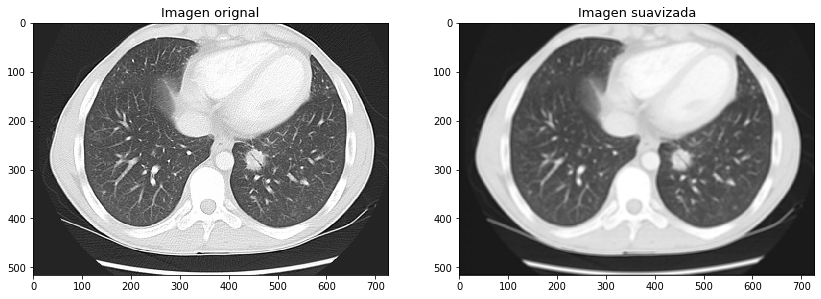

In [19]:
# Filtro suavizante...
N = 7 # dimensión del filtro
FS = np.ones((N,N))*1/N**2

# Convoluciono..
img_s = ss.convolve(img, FS, mode='same');
#img_s = img_s.astype(img.dtype)

# Visualizo..
def visualizar(imgs, subtit2, vmax=None):
    ncols = len(imgs)
    fig, ax = plt.subplots(1, ncols, figsize=(ncols*7,5))
    for axx, im, tit in zip(ax, imgs, ['orignal']+[*subtit2]):
        axx.imshow(im, cmap='gray', vmax=vmax)
        axx.set(title='Imagen ' + tit)
    return

visualizar([img, img_s], ['suavizada'])

***Usando una función de `scipy`...***

In [14]:
img_s2 = si.uniform_filter(img.astype(np.float64), N, mode='constant')
print('La imagen suavizada es igual: ', np.allclose(img_s, img_s2))

La imagen suavizada es igual:  True


***Mirando el espectro de magnitud...***

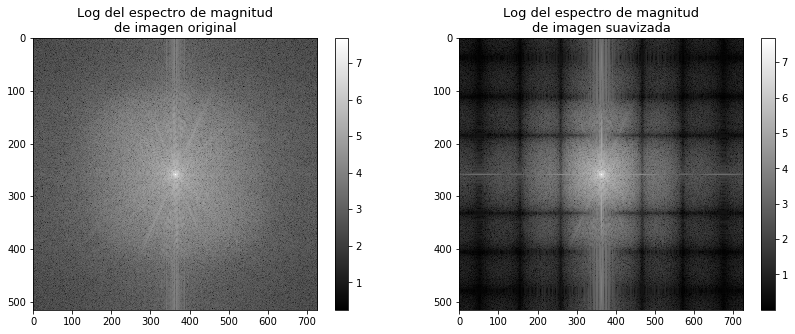

In [15]:
# Defino función que aplica la FFT, el shift para centrar, calcula el módulo de F(w) y muestra usando escala log..
def mi_fft(Z, fm=None, fig=True, rax=False):
    # Paso a dom frecuencia..
    F = scipy.fft.fft2(Z)
    F = scipy.fft.fftshift(F)
    M = abs(F)
    return M

# Otra para comparar espectros..
def visualizar_f(imgs, subt):
    fig, ax = plt.subplots(1,2,figsize=(14,5))
    for axx, im, tit in zip(ax, imgs, subt):
        M = mi_fft(im, fig=False, rax=False)
        axx.set_title('Log del espectro de magnitud\nde imagen '+tit)
        cb = axx.imshow(np.log10(M+1), aspect='auto', cmap='gray')
        fig.colorbar(cb, ax=axx)
    return

visualizar_f([img, img_s], ['original', 'suavizada'])

***
***Aplico filtro suavizante gaussiano...***

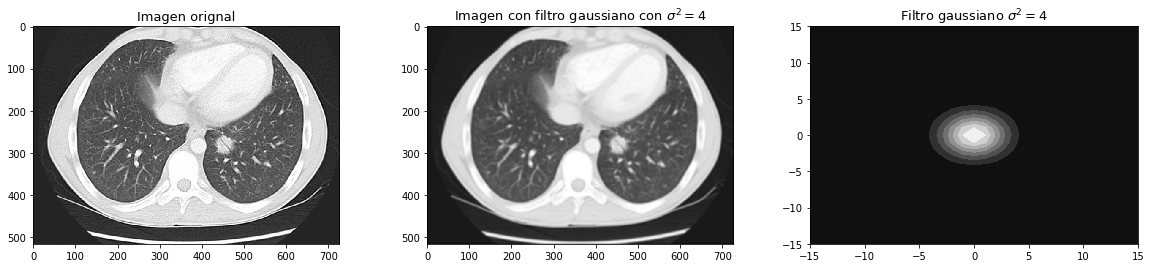

In [16]:
N =  30 # dimensión del filtro
N_ = N//2

# Secuencia de filtros suavizantes con desvios decrecientes..
for de in np.append(np.logspace(3,-2,6), 4):
    # Creo el filtrosuavizante gaussiano
    x, y = np.meshgrid(np.arange(-N_,N_+1), np.arange(-N_,N_+1))
    pos = np.dstack((x, y))
    FS_g = st.multivariate_normal(mean=[0,0], cov=de).pdf(pos)
    plt.pause(0.2)
    display.clear_output(wait=True)
    
    # Convoluciono..
    img_sg = ss.convolve(img, FS_g, mode='same');
    
    # Visualizo..
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    for axx, im, tit in zip(ax[0:2], [img, img_sg], ['orignal', 'con filtro gaussiano con $\sigma^2 = {:.1g}$'.format(de)]):
        axx.imshow(im, cmap='gray')
        axx.set(title='Imagen ' + tit)
    
    # Muestro el filtro..
    ax[2].contourf(x, y, FS_g, cmap='gray')
    ax[2].set(title='Filtro gaussiano $\sigma^2 = {:.1g}$'.format(de))

***Usando una función de `scipy`...***

La imagen suavizada es igual:  True


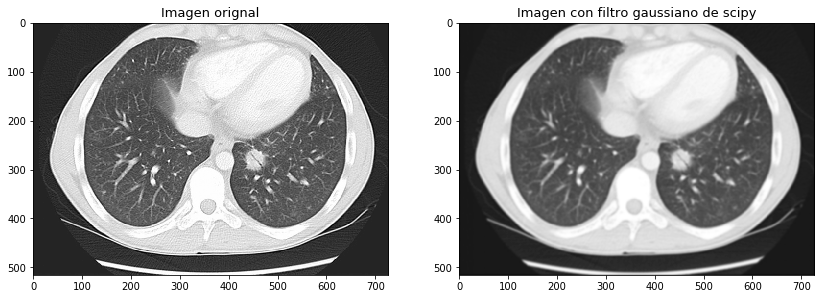

In [20]:
img_sg2 = si.gaussian_filter(img.astype(np.float64), sigma=de**(1/2), mode='constant')
visualizar([img, img_sg2], ['con filtro gaussiano de scipy'])
print('La imagen suavizada es igual: ', np.allclose(img_sg, img_sg2, atol=1e-2))

***Miro el espectro...***

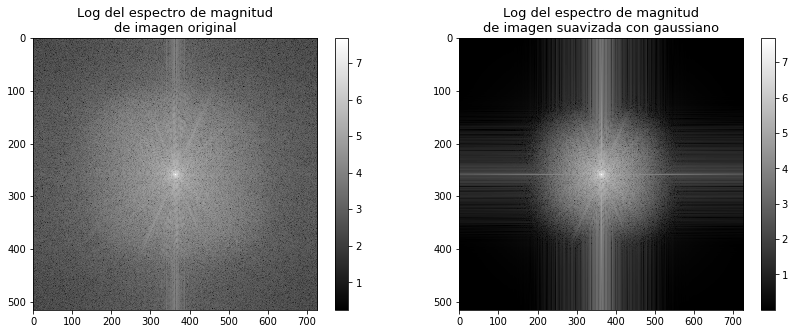

In [21]:
visualizar_f([img, img_sg], ['original', 'suavizada con gaussiano'])

***Puede verse como aún cuando se aplica en el dominio espacial la operación está filtrando frecuencias, dejando pasar las bajas y eliminando las altas. Resulta lógico porque las altas están asociadas a las transiciones abruptas, muy típicas de los bordes/ruido que es lo que en el dominio espacial vemos que este filtro está atenuando.***

***
***Aplico filtro laplaciano...***

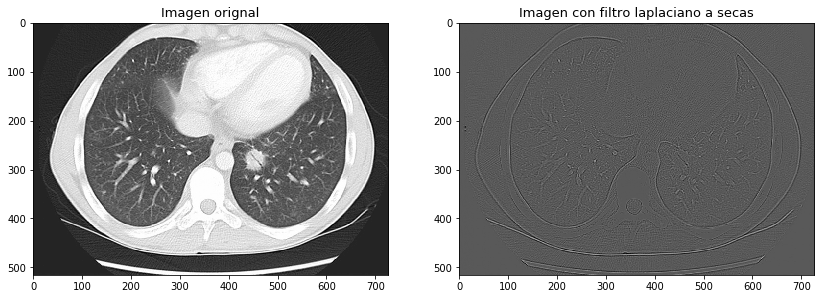

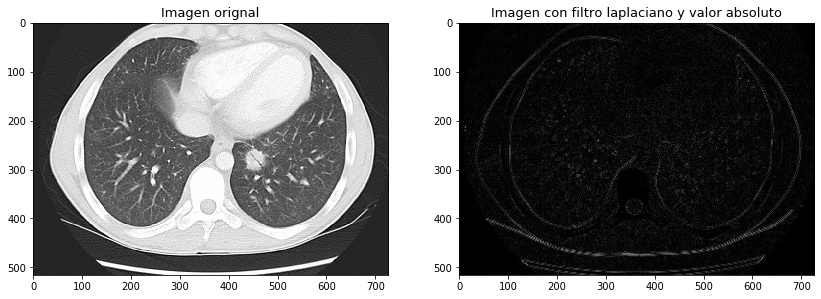

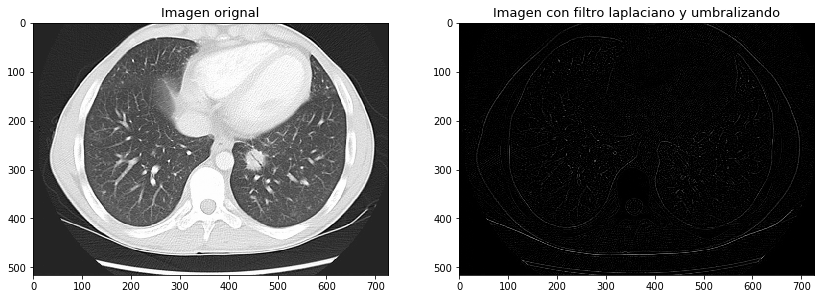

In [22]:
# Filtro laplaciano...
N = 3 # dimensión del filtro
FL = -np.ones((N,N))

# Filtro con diagonales..
FL[(N//2,N//2)] = N**2-1

# Filtro son diagonales..
FL2 = np.zeros((3,3))
FL2[0,1], FL2[1,0], FL2[1,1], FL2[1,2], FL2[2,1] = -1, -1, 4, -1, -1 

#img = img.astype(np.float64)

# Convoluciono..
img_l = ss.convolve(img, FL, mode='same');

# Visualizo..
visualizar([img, img_l], ['con filtro laplaciano a secas'])

# Visualizo con valor absouto..
visualizar([img, abs(img_l)], ['con filtro laplaciano y valor absoluto'])

# Visualizo umbralizando en 0..
visualizar([img, np.where(img_l>=0, img_l,0)], ['con filtro laplaciano y umbralizando'])

***Usando una función de `scipy`...***

In [23]:
img_lb = ss.convolve(img, -FL2, mode='same')
img_l2 = si.laplace(img.astype(np.float64), mode='constant')
print('La imagen suavizada es igual: ', np.allclose(img_lb, img_l2, atol=1))

La imagen suavizada es igual:  True


***Miro el espectro...***

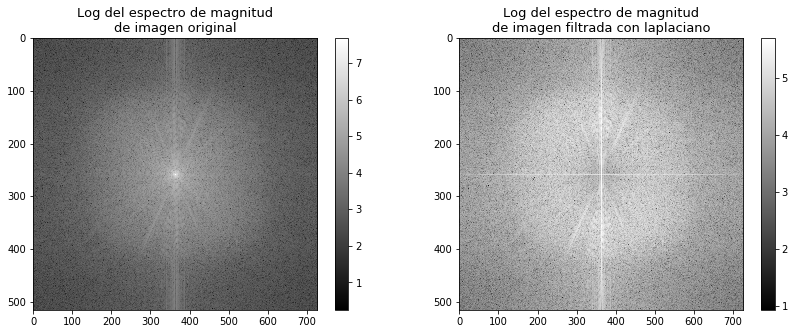

In [24]:
visualizar_f([img, img_l], ['original', 'filtrada con laplaciano'])

***En este caso, a diferencia del previo, se observa que las frecuencias más altas de la periferia son las que incrementan su intensidad mientras que las bajas, que ocupan el centro de la visualización, disminuyen.<br><br>
Mirando la diferencia se puede ver más claramente las frecuencias que enfatiza el filtro laplaciano...***

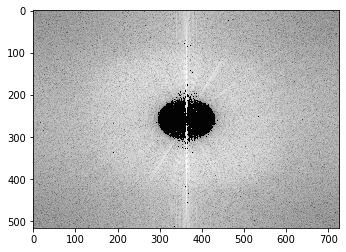

In [25]:
M_img = mi_fft(img, fig=False, rax=False)
M_img_l = mi_fft(img_l, fig=False, rax=False)
M_dif = M_img_l - M_img
plt.imshow(np.log(np.where(M_dif>0,M_dif,1)), cmap='gray');

***
***c) Como se habló en clase, una forma de obtener una imagen con los bordes realzados sin perder el resto de la información útil podría ser sumar la imagen original con la que se obtuvo a partir del filtro laplaciano.<br>
<br>
Primero, tomo el valor absoluto del laplaciano para volver todos los bordes (finos) positivos, lo llevo a uint8 y miro su histograma...***

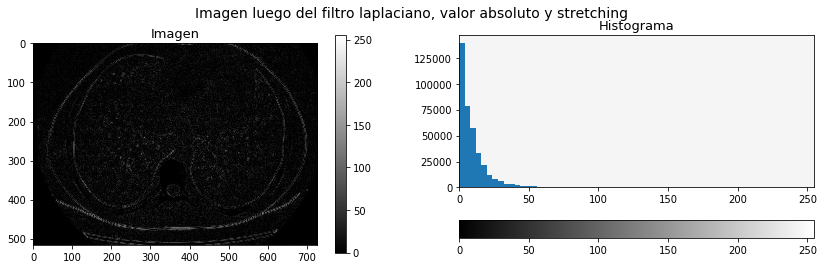

In [26]:
img_l_ = abs(img_l)

# Armo una función para mostrar imagen e histograma..
def visualizar_h(img, bd=8, tit='original', yscale='linear', figsize=(14,4), nrowscols=(1,2), bins=64):
    fig, ax = plt.subplots(*nrowscols, figsize=figsize)
    fig.suptitle('Imagen '+tit, fontsize=14)
    cb = ax[0].imshow(img, cmap='gray', vmin=0, vmax=2**bd-1); 
    fig.colorbar(cb, ax=ax[0]);
    ax[0].set(title='Imagen')
    ax[1].hist(img.ravel(), bins=bins, range=(0,2**bd-1));
    ax[1].set(xlim=(0, 2**bd-1), yscale=yscale, facecolor='whitesmoke', title='Histograma');
    fig.colorbar(cb, ax=ax[1], orientation='horizontal');
    return fig

# Función para expandir histograma..
def contraste(img, umb_min=None, umb_max=None, dtype=None, bd=None): 
    if umb_min is None: umb_min = img.min() 
    if umb_max is None: umb_max = img.max() 
    if dtype is None: dtype = img.dtype 
    if bd is None: bd = img.nbytes*8/img.size 
    img = np.where(img<umb_min, umb_min, img) 
    img = np.where(img>umb_max, umb_max, img) 
    return (((img - umb_min)/(umb_max - umb_min))*(2**bd-1)).astype(dtype)

img_l_ = contraste(img_l_, bd=8, dtype=img.dtype)
visualizar_h(img_l_, tit='luego del filtro laplaciano, valor absoluto y stretching');

***Para sumarla con la imagen original debo converitrlo en un tipo que admita valores mayores a 255, y luego volver a uint8 expandiendo para ocupar todo el rango o acumulando en en el mayor valor del mismo.*** 

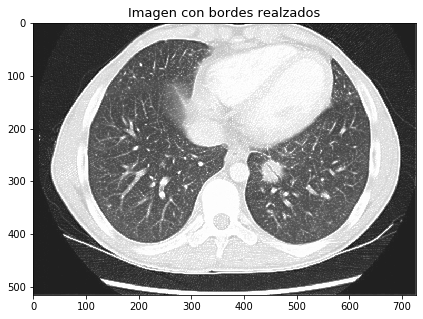

In [27]:
# Armo una función para la suma..
def suma(*imgs, dtype=None, bd=8, umb_min=None, umb_max=None, contrast=True):
    if dtype is None: dtype = imgs[0].dtype
    img_r = 0
    for img in imgs:
        img_r += img.astype(np.float64)
    if contrast:
        img_r = contraste(img_r, dtype=dtype, bd=bd, umb_min=umb_min, umb_max=umb_max)
    else:
        img_r = np.where(img_r>255,255,img_r).astype(dtype) 
    return img_r

# Sumo la función al laplaciano, y clampeo en el máximo.. 
k = 1
img_r = suma(img, k*img_l_, contrast=False)

# Grafico..
fig, ax = plt.subplots(1, 1, figsize=(8,5))
ax.imshow(img_r, cmap='gray', vmax=2**8)
ax.set(title='Imagen con bordes realzados');

#visualizar_h(img_r, tit='con bordes realzados')
#img_r = contraste(img_r, umb_min=40, bd=8)

***
***

# 4.6 Actividad 12

>***a) Abrir una imagen y agréguele ruido gaussaiano, impulsivo y uniforme.<br>
b) Mostrar el resultado de filtrar la imagen con ruido con dos diferentes filtros espaciales (al menos dos, uno no lineal y otro lineal).<br>
c) ¿Cuál de los filtros aplicados parece tener un mejor desempeño para corregir el ruido?***

***Sigo usando la imagen del tórax. Primero le agrego los ruidos. Primero cada ruido por separado, para ver los efectos de cada uno y luego todos juntos...*** 

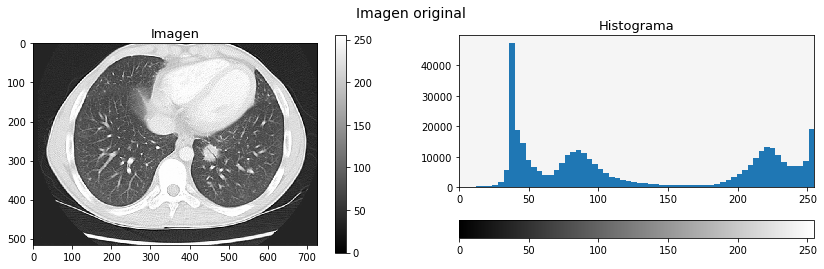

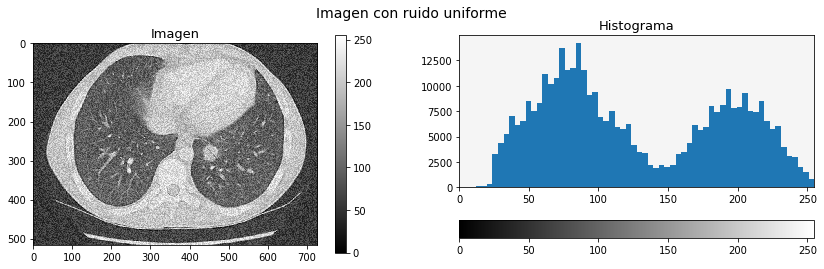

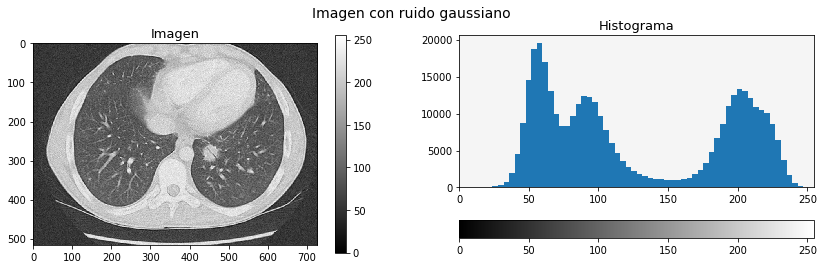

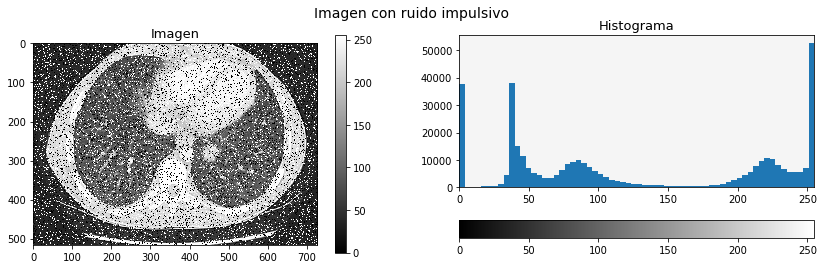

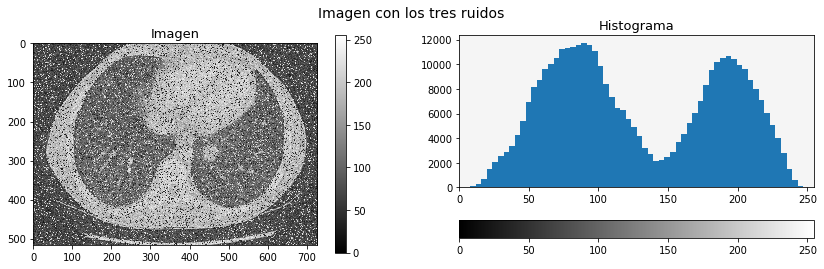

In [28]:
# ORIGINAL
visualizar_h(img)

# RUIDO UNIFORME..
a = 10
b = 100
Ru = st.randint(a, b).rvs((img.shape))
#img_ru = img.astype(np.float64) + Ru.astype(np.float64)
#img_ru = contraste(img_ru, dtype=img.dtype, bd=8)
img_ru = suma(img, Ru)
visualizar_h(img_ru, tit='con ruido uniforme');

# RUIDO GAUSSIANO..
mu = 100
de = 9
Rn = st.norm(mu, de).rvs(size=(img.shape))
img_rn = suma(img, Rn)
visualizar_h(img_rn, tit='con ruido gaussiano');

# RUIDO IMPULSIVO..
# Función p/incorporar ruido impulsivo a una imagen...
def ruido_syp(img, umb=0.1):
    img_r = img.copy()
    D = st.uniform().rvs(img.shape)
    img_r[D<umb] = 0
    img_r[D>(1-umb)] = 255
    return img_r

img_ri = ruido_syp(img)
visualizar_h(img_ri, tit='con ruido impulsivo')

# TODOS LOS RUIDOS
img_rt = suma(img_ri, Ru, Rn)
visualizar_h(img_rt, tit='con los tres ruidos');

***Aplico filtrado con promedio simple (lineal) y mediana (no lineal), con tres tamaños de kernel...***

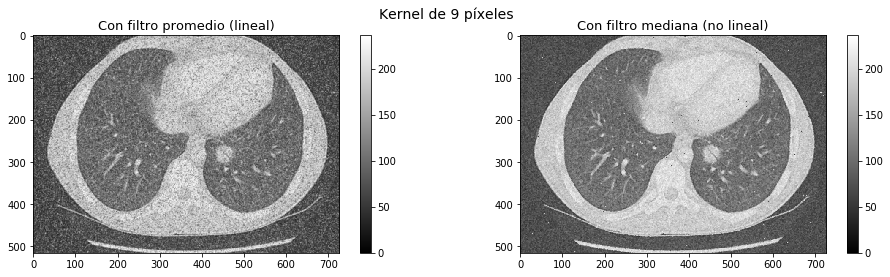

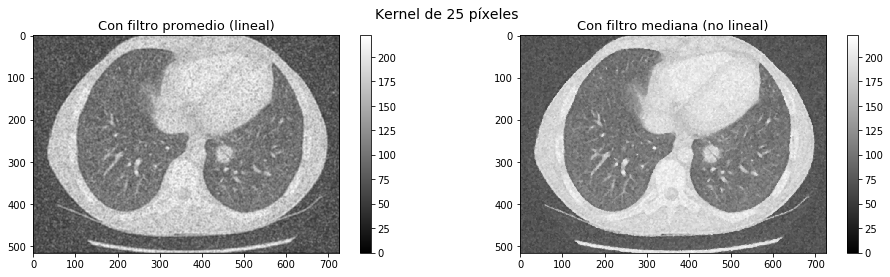

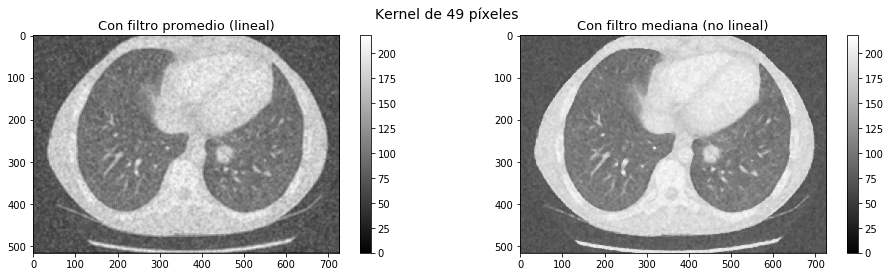

In [31]:
for N in [3, 5, 7]:
    fig, ax = plt.subplots(1,2,figsize=(16,4), gridspec_kw={'hspace':0.1})
    fig.suptitle('Kernel de {} píxeles'.format(N**2), fontsize=14)
    _img_fl = si.uniform_filter(img_rt.astype(np.float64), N, mode='constant')
    cb = ax[0].imshow(_img_fl, cmap='gray')
    ax[0].set_title('Con filtro promedio (lineal)')
    _img_fnl = ss.medfilt(img_rt.astype(np.float64), N)
    cb = ax[1].imshow(_img_fnl, cmap='gray')
    ax[1].set_title('Con filtro mediana (no lineal)')
    fig.colorbar(cb, ax=ax[0])
    fig.colorbar(cb, ax=ax[1])

***A medida que se incrementa el tamaño del kernel, la eliminación del ruido es mayor, pero la imagen pierde cada vez más nitidez, resultando en una relación de compromiso que hay que sopesar.<br>
En cuanto a la comparación de los tipos de filtros, se observa que en general, para los tres tamaños de kernel, el filtro de mediana tiene mejor desempeño en reducción del ruido, sobre todo el impulsivo, lo cual se evidencia con mayor notoriedad en la zona bien clara del corazón o en la periferia de baja intensidad.***

***
***
<h1 style="color:green;font-size:50px;"><center>FIN!</center></h1>

***
***
***